In [38]:
%matplotlib inline
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from scribe_classifier.data.canada import AllCodes, TitleSet, SimpleModel, CombinedModels
from sklearn import metrics
import numpy as np
from scipy.stats import stderr, mean

ImportError: cannot import name 'stderr'

In [2]:
all_codes = AllCodes.load_from_pickle("./source_data/pickles/canada/tidy_sets/all_codes.P", is_path=True)
emptyset_label = "NA"
all_codes.add_emptyset()
test = dict()
train = dict()
valid = dict()
mdl = dict()
valid_preds = dict()
test_preds = dict()
acv = dict()
for i in range(1,4):
    acv[i] = all_codes.get_codes_for_level(target_level=i)
    target_level = i

    valid[i] = TitleSet.load_from_pickle('source_data/pickles/canada/test_sets/valid.set.lvl%d.P' % target_level, is_path=True)
    test[i] = TitleSet.load_from_pickle('source_data/pickles/canada/test_sets/test.set.lvl%d.P' % target_level, is_path=True)
    train[i] = TitleSet.load_from_pickle('source_data/pickles/canada/test_sets/train.set.lvl%d.P' % target_level, is_path=True)

    valid[i] = valid[i].copy_and_append_empty_string_class(label=emptyset_label, prop_records=0.25)
    test[i] = test[i].copy_and_append_empty_string_class(label=emptyset_label, prop_records=0.25)
    mdl[i] = SimpleModel.load_from_pickle(
        "./source_data/pickles/canada/trained_models/simple.lvl%d.P" % target_level,
        is_path=True
    )
    valid_preds[i] = mdl[i].predict_titleset(valid[i])
    test_preds[i] = mdl[i].predict_titleset(test[i])

In [3]:
valid_ys = dict()
test_ys = dict()
for i in range(1,4):
    vY=valid[i].get_code_vec(target_level=i)
    tY=test[i].get_code_vec(target_level=i)
    valid_ys[i] = vY
    test_ys[i] = tY

In [34]:
test_evals = dict()
valid_evals = dict()
test_acc = dict()
valid_acc = dict()
def eval_level(target_level:int=1):
    valid_p = valid_preds[target_level] 
    test_p = test_preds[target_level]
    valid_y = valid_ys[target_level]
    test_y = test_ys[target_level]
    #  [precision, recall, fbeta_score, support]
    valid_eval = list(metrics.precision_recall_fscore_support(valid_y, valid_p, labels=acv[target_level], average=None))
    test_eval = list(metrics.precision_recall_fscore_support(test_y, test_p, labels=acv[target_level], average=None))
#     print("valid size:", len(valid_p))
#     print("test size:", len(test_p))
#     print("valid eval size: ", len(valid_eval))
#     print("test eval: size", len(test_eval))
#     print(type(valid_eval[0]))
#     print(type(test_eval[0]))
    test_evals[target_level] = test_eval
    valid_evals[target_level] = valid_eval
    valid_acc[target_level] = metrics.accuracy_score(valid_y, valid_p)
    test_acc[target_level] = metrics.accuracy_score(test_y, test_p)

for i in range(1,4):
    eval_level(i)


In [40]:
#std error for error bars std_dev / sqrt(samp_size)
def get_prec(evals, acv):
    df = pd.DataFrame()
    df['Class'] = pd.Series(acv)
    df['Precision'] = pd.Series(evals[0])
    avg = df['Precision'].mean()
    std_err = df['Precision'].std() / np.sqrt(len(df['Class']))
    return avg, std_err
def get_recall(evals, acv):
    df = pd.DataFrame()
    df['Class'] = pd.Series(acv)
    df['Recall'] = pd.Series(evals[1])
    avg = df['Recall'].mean()
    std_err = df['Recall'].std() / np.sqrt(len(df['Class']))
    return avg, std_err
def get_f1(evals, acv):
    df = pd.DataFrame()
    df['Class'] = pd.Series(acv)
    df['F1 Score'] = pd.Series(evals[2])
    avg = df['F1 Score'].mean()
    std_err = df['F1 Score'].std() / np.sqrt(len(df['Class']))
    return avg, std_err

In [51]:
def plot_prec(evals, acv):
    avgs = []
    std_errs = []
    levels = []
    for i in range(1,4):
        avg, std_err = get_prec(evals[i], acv[i])
        avgs.append(avg)
        std_errs.append(std_err)
        levels.append(i)
    df = pd.DataFrame()
    df['Class Level'] = pd.Series(levels)
    df['Avg Precision'] = pd.Series(avgs)
    df['Std Err Precision'] = pd.Series(std_errs)
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    ax.set_autoscaley_on(False)
    ax.set_ylim([0,1])
    sn.barplot(data=df, x='Class Level', y='Avg Precision', ax=ax, yerr=df['Std Err Precision'])
    
def plot_recall(evals, acv):
    avgs = []
    std_errs = []
    levels = []
    for i in range(1,4):
        avg, std_err = get_recall(evals[i], acv[i])
        avgs.append(avg)
        std_errs.append(std_err)
        levels.append(i)
    df = pd.DataFrame()
    df['Class Level'] = pd.Series(levels)
    df['Avg Recall'] = pd.Series(avgs)
    df['Std Err Recall'] = pd.Series(std_errs)
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    ax.set_autoscaley_on(False)
    ax.set_ylim([0,1])
    sn.barplot(data=df, x='Class Level', y='Avg Recall', ax=ax, yerr=df['Std Err Recall'])
    
def plot_f1(evals, acv):
    avgs = []
    std_errs = []
    levels = []
    for i in range(1,4):
        avg, std_err = get_f1(evals[i], acv[i])
        avgs.append(avg)
        std_errs.append(std_err)
        levels.append(i)
    df = pd.DataFrame()
    df['Class Level'] = pd.Series(levels)
    df['Avg F1 Score'] = pd.Series(avgs)
    df['Std Err F1 Score'] = pd.Series(std_errs)
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    ax.set_autoscaley_on(False)
    ax.set_ylim([0,1])
    sn.barplot(data=df, x='Class Level', y='Avg F1 Score', ax=ax, yerr=df['Std Err F1 Score'])
        
def plot_acc(accs, acv, title):
    pass
    

In [47]:
plt.figure(figsize = (100,70))

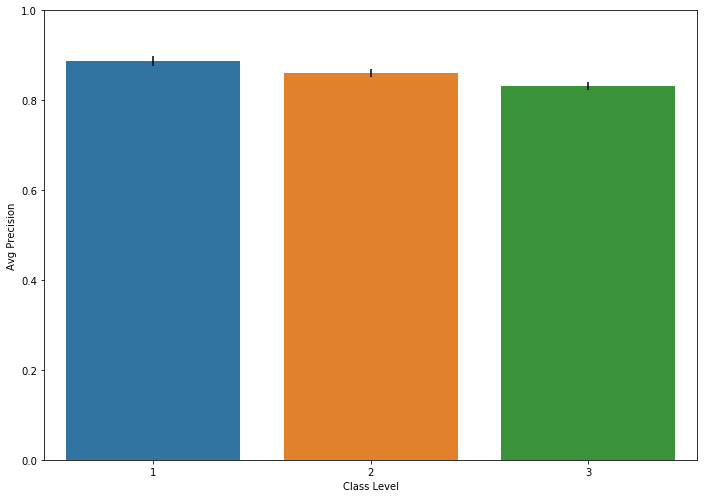

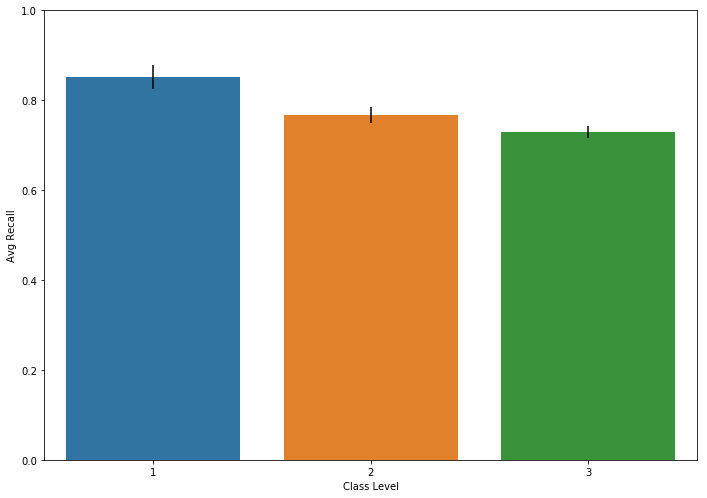

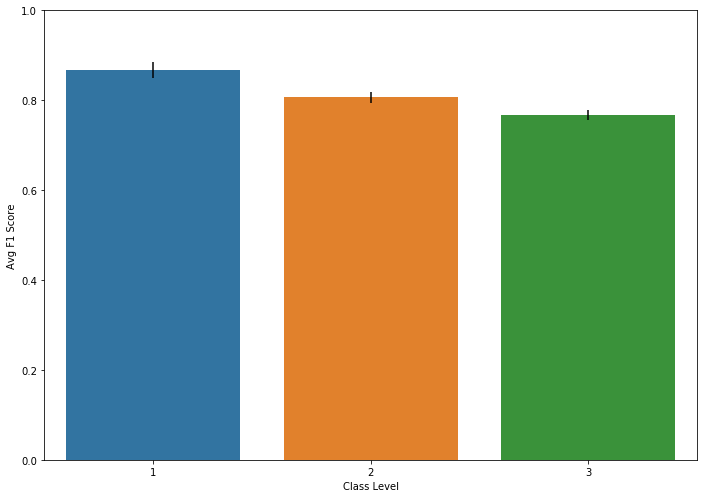

In [53]:
plot_prec(valid_evals,acv)
plot_recall(valid_evals,acv)
plot_f1(valid_evals,acv)